In [19]:
import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [20]:
fun = Ackley(dim=20, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [21]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

In [22]:
def get_fitted_model_gp(train_x, train_obj, state_dict=None):
    # initialize and fit model
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        train_X=train_x, 
        train_Y=train_obj,
        covar_module=covar_module,
        likelihood=likelihood
    )
    
    if state_dict is not None:
        model.load_state_dict(state_dict)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_mll(mll)
    return model

In [23]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a
    new candidate and a noisy observation"""

    # optimize
    X_next, _ = optimize_acqf(
        acq_function=acq_func,
        bounds = fun.bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values
    # new_x = unnormalize(candidates.detach(), bounds=bounds)
    # new_obj = score_image(decode(new_x)).unsqueeze(-1)
    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)
    return X_next, Y_next

In [24]:
# BO start!
import warnings

train_x = get_initial_points(dim, n_init)
train_obj = torch.tensor(
    [eval_objective(x) for x in train_x], dtype=dtype, device=device
).unsqueeze(-1)


NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4

torch.manual_seed(0)

warnings.filterwarnings("ignore")
N_BATCH = 25
state_dict = None
best_observed = []

for iteration in range(N_BATCH):
    # fit the model
    model = get_fitted_model_gp(
        train_x=train_x,
        train_obj=train_obj,
        state_dict=state_dict,
    )

    # define the qNEI acquisition function
    qEI = qExpectedImprovement(
        model=model, best_f=train_obj.max()
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)

    state_dict = model.state_dict()

    print(".", end="")
    
Y_qEI = train_obj

.........................

## GP-qEI

In [31]:
torch.manual_seed(0)

X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor(
    [eval_objective(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)

while len(Y_ei) < 400:
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

44) Best value: -1.12e+01
48) Best value: -1.06e+01
52) Best value: -9.68e+00
56) Best value: -9.27e+00
60) Best value: -8.59e+00
64) Best value: -8.59e+00
68) Best value: -8.59e+00
72) Best value: -8.59e+00
76) Best value: -8.59e+00
80) Best value: -8.59e+00
84) Best value: -8.59e+00
88) Best value: -8.59e+00
92) Best value: -8.59e+00
96) Best value: -8.59e+00
100) Best value: -8.59e+00
104) Best value: -8.59e+00
108) Best value: -8.59e+00
112) Best value: -8.59e+00
116) Best value: -8.59e+00
120) Best value: -8.59e+00
124) Best value: -8.59e+00
128) Best value: -8.59e+00
132) Best value: -8.59e+00
136) Best value: -8.59e+00
140) Best value: -8.59e+00
144) Best value: -8.59e+00
148) Best value: -8.59e+00
152) Best value: -8.59e+00
156) Best value: -8.59e+00
160) Best value: -8.59e+00
164) Best value: -8.59e+00
168) Best value: -8.59e+00
172) Best value: -8.59e+00
176) Best value: -8.59e+00
180) Best value: -8.59e+00
184) Best value: -8.59e+00
188) Best value: -8.59e+00
192) Best value

## NP-qEI

In [13]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections

import math
%pylab inline

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from ANP import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\82109\anaconda3\envs\botorch_ex\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)

In [11]:
model = LatentModel(1, 1, 64, latent_enc_self_attn_type="multihead", det_enc_self_attn_type="multihead",
                   det_enc_cross_attn_type="multihead")
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

1. https://github.com/EmilienDupont/neural-processes/blob/master/neural_process.py
2. https://chrisorm.github.io/NGP.html
3. https://kasparmartens.rbind.io/post/np, https://github.com/kasparmartens/NeuralProcesses (먼저 읽기)


In [ ]:
from botorch.posteriors.gpytorch import GPyTorchPosterior



In [ ]:
torch.manual_seed(0)

X_np_ei = get_initial_points(dim, n_init)
Y_np_ei = torch.tensor(
    [eval_objective(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)

## for NP training
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
state_dict = None

while len(Y_np_ei) < 400:
    train_Y = (Y_np_ei - Y_np_ei.mean()) / Y_np_ei.std()

    ##
    # likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    # model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    # mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # fit_gpytorch_mll(mll)
    model = get_fitted_model(dataset_train=dataset_train, dataset_test=dataset_test, state_dict=state_dict, optim=optim)
    ##

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_np_ei = torch.cat((X_np_ei, candidate), axis=0)
    Y_np_ei = torch.cat((Y_np_ei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_np_ei)}) Best value: {Y_np_ei.max().item():.2e}")

## Plot

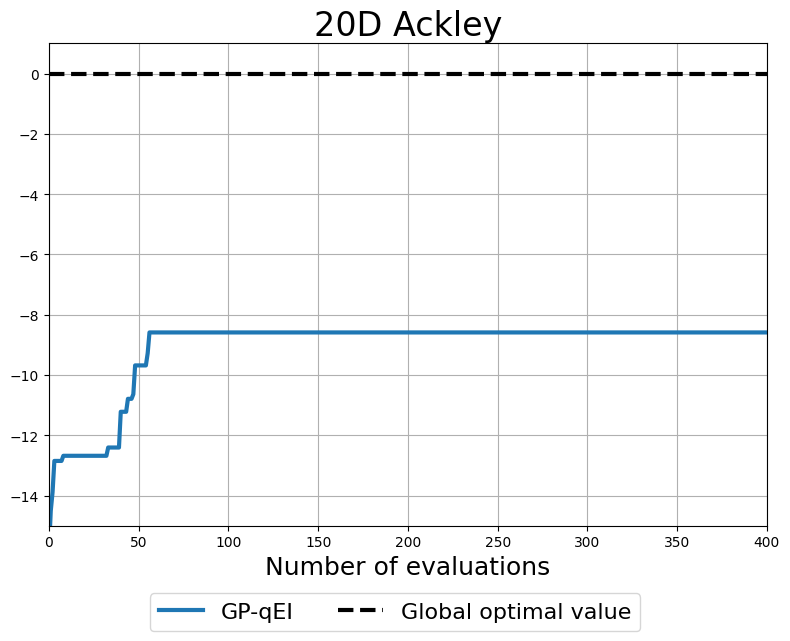

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

names = ["GP-qEI"] # , "EI", "Sobol"
runs = [Y_ei] # , Y_ei, Y_Sobol
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_ei)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_ei)])
plt.ylim([-15, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()